## Loading data

In [ ]:
import numpy as np
from tqdm import tqdm
import os
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch import nn
import torchvision
import torch
import scipy.io
import matplotlib.pyplot as plt

In [ ]:
# Mounting colab
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Stanfard Car Dataset directory
base_path = '/content/drive/My Drive/301_Project/Datasets/Stanfard_Car_Datasets'
base_path = './data'
# Train and test images dataset path
cars_train_path = f'{base_path}/cars_train'
cars_test_path = f'{base_path}/cars_test'
# Annotations mat file path
annotations_path = f'{base_path}/cars_annos.mat'
annotations_train_path = f'{base_path}/cars_train_annos.mat'
annotations_test_path = f'{base_path}/cars_test_annos.mat'

class_names = [i[0] for i in scipy.io.loadmat(annotations_path)['class_names'][0]]
print(f'There are {len(class_names)} classes in the dataset')

There are 196 classes in the dataset


In [ ]:

class StanfordCarsDataset(Dataset):
    def __init__(self, directory, image_label_dict, transform=None):
        self.directory = directory
        self.image_label_dict = image_label_dict
        self.transform = transform
        self.images = list(image_label_dict.keys())

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = os.path.join(self.directory, self.images[idx])
        image = Image.open(image_path).convert('RGB')
        label = self.image_label_dict[self.images[idx]]
        if self.transform:
            image = self.transform(image)
        return image, label

train_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        # transforms.RandomHorizontalFlip(), # Flip the image horizontally with a 50% chance
        # transforms.RandomRotation(20), # Rotate image by 20 degrees
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

test_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])


# load the datasets
train_dataset_raw = torch.load('./dataset_new/train_dataset_raw.pth')
test_dataset_pseudo = torch.load('./dataset_new/test_dataset_pseudo.pth')
test_dataset_pseudo_no_threshold = torch.load('./dataset_new/test_dataset_pseudo_no_threshold.pth')

train_dataset = torch.utils.data.ConcatDataset([train_dataset_raw, test_dataset_pseudo])
train_dataset_no_threshold = torch.utils.data.ConcatDataset([train_dataset_raw, test_dataset_pseudo_no_threshold])
test_dataset = torch.load('./dataset_new/test_dataset.pth')

# show the dataset size
print(f'Train dataset size: {len(train_dataset)}')
print(f'Test dataset size: {len(test_dataset)}')

Train dataset size: 13850
Test dataset size: 8041


## Finetune ViT on the Pseudo Labeling dataset

### Using the previously best hyperparameters

In [ ]:
# Updated training function with scheduler
def train_one_epoch(model, dataloader, loss_fn, optimizer, device):
    model.train()
    total_loss, total_correct = 0, 0
    for inputs, labels in tqdm(dataloader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        total_correct += torch.sum(preds == labels.data)
    return total_loss / len(dataloader), total_correct.double() / len(dataloader.dataset)


def evaluate(model, dataloader, loss_fn, device):
    model.eval()
    total_loss, total_correct = 0, 0
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            total_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            total_correct += torch.sum(preds == labels.data)
    return total_loss / len(dataloader), total_correct.double() / len(dataloader.dataset)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the function to unfreeze layers
def unfreeze_layers(model, num_unfreeze_layers):
    for param in model.parameters():
        param.requires_grad = False
    encoder_layers = model.vit.encoder.layers
    num_blocks = len(encoder_layers)
    blocks_to_unfreeze = num_blocks - num_unfreeze_layers
    for i in range(blocks_to_unfreeze, num_blocks):
        for param in encoder_layers[i].parameters():
            param.requires_grad = True

100%|██████████| 289/289 [00:36<00:00,  7.92it/s]


Epoch 1, Train Loss: 2.931, Train Accuracy: 0.415


100%|██████████| 168/168 [00:11<00:00, 14.29it/s]


Test Loss: 1.387, Test Accuracy: 0.705


100%|██████████| 289/289 [00:34<00:00,  8.27it/s]


Epoch 2, Train Loss: 0.785, Train Accuracy: 0.834


100%|██████████| 168/168 [00:11<00:00, 14.21it/s]


Test Loss: 0.943, Test Accuracy: 0.783


100%|██████████| 289/289 [00:34<00:00,  8.29it/s]


Epoch 3, Train Loss: 0.374, Train Accuracy: 0.916


100%|██████████| 168/168 [00:11<00:00, 14.28it/s]


Test Loss: 0.923, Test Accuracy: 0.795


100%|██████████| 289/289 [00:34<00:00,  8.32it/s]


Epoch 4, Train Loss: 0.228, Train Accuracy: 0.949


100%|██████████| 168/168 [00:11<00:00, 14.13it/s]


Test Loss: 0.897, Test Accuracy: 0.809


100%|██████████| 289/289 [00:35<00:00,  8.22it/s]


Epoch 5, Train Loss: 0.178, Train Accuracy: 0.963


100%|██████████| 168/168 [00:11<00:00, 14.11it/s]


Test Loss: 0.984, Test Accuracy: 0.796


100%|██████████| 289/289 [00:34<00:00,  8.33it/s]


Epoch 6, Train Loss: 0.189, Train Accuracy: 0.957


100%|██████████| 168/168 [00:11<00:00, 14.29it/s]


Test Loss: 0.972, Test Accuracy: 0.803


100%|██████████| 289/289 [00:34<00:00,  8.32it/s]


Epoch 7, Train Loss: 0.159, Train Accuracy: 0.966


100%|██████████| 168/168 [00:11<00:00, 14.28it/s]


Test Loss: 0.997, Test Accuracy: 0.803


100%|██████████| 289/289 [00:34<00:00,  8.34it/s]


Epoch 8, Train Loss: 0.110, Train Accuracy: 0.975


100%|██████████| 168/168 [00:11<00:00, 14.23it/s]


Test Loss: 0.958, Test Accuracy: 0.811


100%|██████████| 289/289 [00:34<00:00,  8.35it/s]


Epoch 9, Train Loss: 0.073, Train Accuracy: 0.985


100%|██████████| 168/168 [00:11<00:00, 14.26it/s]


Test Loss: 0.998, Test Accuracy: 0.813


100%|██████████| 289/289 [00:34<00:00,  8.35it/s]


Epoch 10, Train Loss: 0.106, Train Accuracy: 0.978


100%|██████████| 168/168 [00:11<00:00, 14.03it/s]


Test Loss: 1.096, Test Accuracy: 0.791


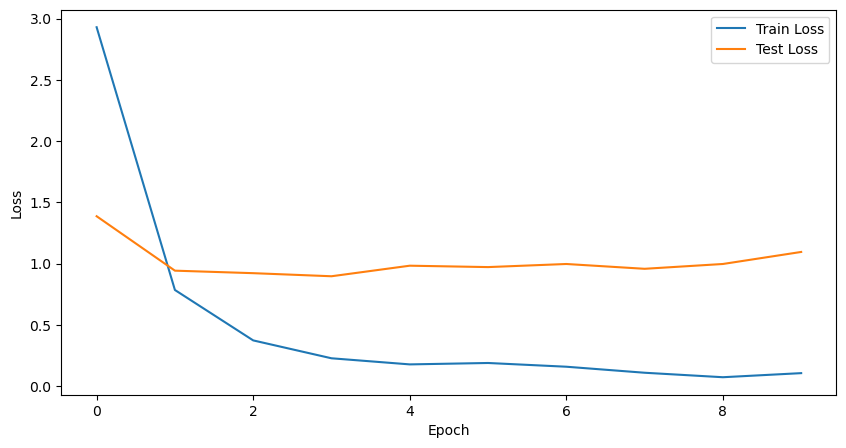

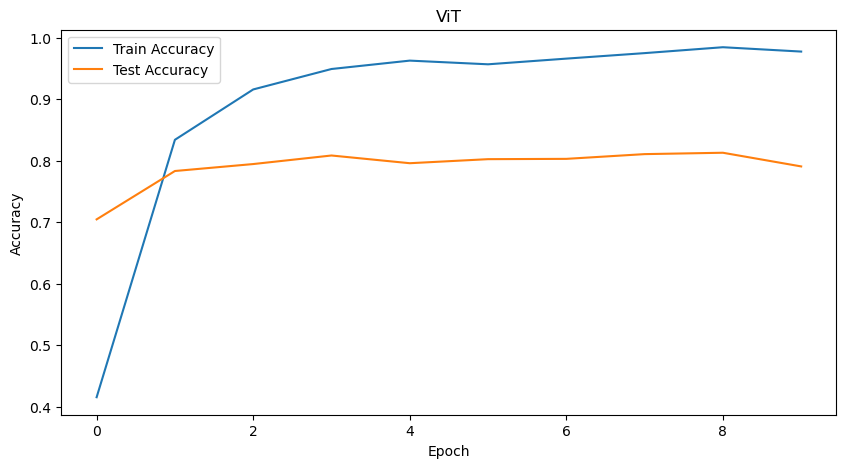

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision.models import vit_b_16, ViT_B_16_Weights

# ViT Model
class ViTModel(nn.Module):
    def __init__(self, num_classes):
        super(ViTModel, self).__init__()
        self.vit = torchvision.models.vit_b_16(weights=ViT_B_16_Weights.IMAGENET1K_V1)
        for param in self.vit.parameters():
            param.requires_grad = False
        self.fc = nn.Linear(1000, num_classes)

    def forward(self, x):
        x = self.vit(x)
        return self.fc(x)

# Best hyperparameters
batch_size = 48
learning_rate = 0.00084
num_unfreeze_layers = 4
epochs = 10 # increase epochs for final training

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=8)

# model, optimizer, and loss function initialization
model = ViTModel(num_classes=len(class_names)).to(device)

# Unfreeze layers
unfreeze_layers(model, num_unfreeze_layers)

# Incorporate scheduler
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, verbose=True)
loss_fn = nn.CrossEntropyLoss()

metrics = {'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': []}

# training loop
for epoch in range(epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, loss_fn, optimizer, device)
    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.3f}, Train Accuracy: {train_acc:.3f}')

    test_loss, test_acc = evaluate(model, test_loader, loss_fn, device)
    print(f'Test Loss: {test_loss:.3f}, Test Accuracy: {test_acc:.3f}')

    # Update the learning rate scheduler with the validation/test loss
    scheduler.step(test_loss)

    metrics['train_loss'].append(train_loss)
    metrics['train_acc'].append(train_acc.item())
    metrics['test_loss'].append(test_loss)
    metrics['test_acc'].append(test_acc.item())

# visualization
plt.figure(figsize=(10, 5))
plt.plot(metrics['train_loss'], label='Train Loss')
plt.plot(metrics['test_loss'], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(metrics['train_acc'], label='Train Accuracy')
plt.plot(metrics['test_acc'], label='Test Accuracy')
plt.title("ViT")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# save the model
Vit_path = './Vit_path_pseudo.pth'
torch.save(model.state_dict(), Vit_path)

### Mixed precision training

In order to speed up the training process, we can use mixed precision training. This technique uses half-precision floating point numbers to speed up the training process. We can use the `torch.cuda.amp` module to achieve this. The `torch.cuda.amp` module provides automatic mixed precision training and allows us to use half-precision floating point numbers for training.

It takes 40 seconds on a single 4090 GPU to train one epoch before mixed precision training. After using mixed precision training, it takes 20 seconds to train one epoch and achieves similar accuracy. So, we can see that mixed precision training speeds up the training process without sacrificing accuracy.

100%|██████████| 289/289 [00:18<00:00, 15.86it/s]


Epoch 1, Train Loss: 2.686, Train Accuracy: 0.486


100%|██████████| 168/168 [00:11<00:00, 14.09it/s]


Test Loss: 1.150, Test Accuracy: 0.770


100%|██████████| 289/289 [00:18<00:00, 15.62it/s]


Epoch 2, Train Loss: 0.591, Train Accuracy: 0.887


100%|██████████| 168/168 [00:11<00:00, 14.20it/s]


Test Loss: 0.811, Test Accuracy: 0.822


100%|██████████| 289/289 [00:18<00:00, 15.33it/s]


Epoch 3, Train Loss: 0.234, Train Accuracy: 0.953


100%|██████████| 168/168 [00:11<00:00, 14.17it/s]


Test Loss: 0.834, Test Accuracy: 0.817


100%|██████████| 289/289 [00:18<00:00, 16.03it/s]


Epoch 4, Train Loss: 0.166, Train Accuracy: 0.966


100%|██████████| 168/168 [00:11<00:00, 14.14it/s]


Test Loss: 0.869, Test Accuracy: 0.822


100%|██████████| 289/289 [00:17<00:00, 16.17it/s]


Epoch 5, Train Loss: 0.138, Train Accuracy: 0.972


100%|██████████| 168/168 [00:11<00:00, 14.23it/s]


Test Loss: 0.914, Test Accuracy: 0.814


100%|██████████| 289/289 [00:18<00:00, 15.81it/s]


Epoch 6, Train Loss: 0.112, Train Accuracy: 0.977


100%|██████████| 168/168 [00:11<00:00, 14.09it/s]


Test Loss: 0.937, Test Accuracy: 0.813


100%|██████████| 289/289 [00:18<00:00, 15.61it/s]


Epoch 7, Train Loss: 0.139, Train Accuracy: 0.971


100%|██████████| 168/168 [00:12<00:00, 13.99it/s]


Test Loss: 0.932, Test Accuracy: 0.819


100%|██████████| 289/289 [00:18<00:00, 15.38it/s]


Epoch 8, Train Loss: 0.127, Train Accuracy: 0.973


100%|██████████| 168/168 [00:11<00:00, 14.06it/s]


Test Loss: 0.940, Test Accuracy: 0.817


100%|██████████| 289/289 [00:18<00:00, 16.01it/s]


Epoch 9, Train Loss: 0.085, Train Accuracy: 0.982


100%|██████████| 168/168 [00:11<00:00, 14.25it/s]


Test Loss: 0.910, Test Accuracy: 0.826


100%|██████████| 289/289 [00:17<00:00, 16.11it/s]


Epoch 10, Train Loss: 0.086, Train Accuracy: 0.983


100%|██████████| 168/168 [00:11<00:00, 14.23it/s]


Test Loss: 1.027, Test Accuracy: 0.809


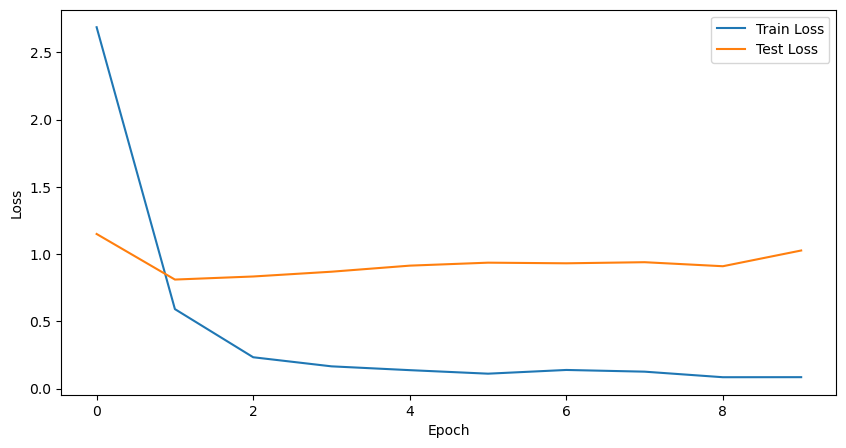

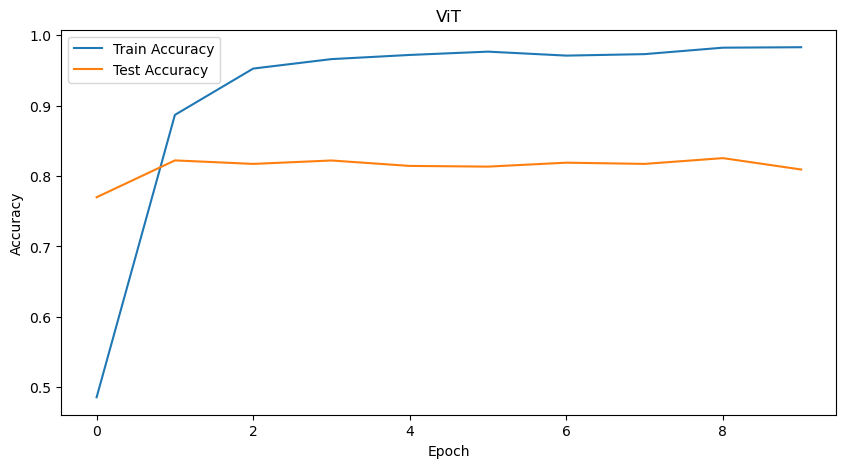

In [ ]:
import torch
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm

def train_one_epoch(model, dataloader, loss_fn, optimizer, device):
    model.train()
    total_loss, total_correct = 0, 0
    scaler = GradScaler()

    for inputs, labels in tqdm(dataloader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        with autocast():
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)

        scaler.scale(loss).backward()

        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        total_correct += torch.sum(preds == labels.data)

    return total_loss / len(dataloader), total_correct.double() / len(dataloader.dataset)


from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision.models import vit_b_16, ViT_B_16_Weights

# ViT Model
class ViTModel(nn.Module):
    def __init__(self, num_classes):
        super(ViTModel, self).__init__()
        self.vit = torchvision.models.vit_b_16(weights=ViT_B_16_Weights.IMAGENET1K_V1)
        for param in self.vit.parameters():
            param.requires_grad = False
        self.fc = nn.Linear(1000, num_classes)

    def forward(self, x):
        x = self.vit(x)
        return self.fc(x)

# Best hyperparameters
batch_size = 48
learning_rate = 0.00084
num_unfreeze_layers = 4
epochs = 10 # increase epochs for final training

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=8)

# model, optimizer, and loss function initialization
model = ViTModel(num_classes=len(class_names)).to(device)

# Unfreeze layers
unfreeze_layers(model, num_unfreeze_layers)

# Incorporate scheduler
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, verbose=True)
loss_fn = nn.CrossEntropyLoss()

metrics = {'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': []}

# training loop
for epoch in range(epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, loss_fn, optimizer, device)
    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.3f}, Train Accuracy: {train_acc:.3f}')

    test_loss, test_acc = evaluate(model, test_loader, loss_fn, device)
    print(f'Test Loss: {test_loss:.3f}, Test Accuracy: {test_acc:.3f}')

    # Update the learning rate scheduler with the validation/test loss
    scheduler.step(test_loss)

    metrics['train_loss'].append(train_loss)
    metrics['train_acc'].append(train_acc.item())
    metrics['test_loss'].append(test_loss)
    metrics['test_acc'].append(test_acc.item())

# visualization
plt.figure(figsize=(10, 5))
plt.plot(metrics['train_loss'], label='Train Loss')
plt.plot(metrics['test_loss'], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(metrics['train_acc'], label='Train Accuracy')
plt.plot(metrics['test_acc'], label='Test Accuracy')
plt.title("ViT")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# save the model
Vit_path = './Vit_path_pseudo.pth'
torch.save(model.state_dict(), Vit_path)

### Experiment with the pseudo labeling dataset without thresholding

We can see that thresholding the pseudo labeling dataset is crucial for achieving good performance, so we will experiment with the pseudo labeling dataset with the thresholding.

100%|██████████| 338/338 [00:21<00:00, 15.38it/s]


Epoch 1, Train Loss: 2.794, Train Accuracy: 0.439


100%|██████████| 168/168 [00:11<00:00, 14.52it/s]


Test Loss: 1.205, Test Accuracy: 0.749


100%|██████████| 338/338 [00:21<00:00, 16.09it/s]


Epoch 2, Train Loss: 0.892, Train Accuracy: 0.802


100%|██████████| 168/168 [00:11<00:00, 14.64it/s]


Test Loss: 0.946, Test Accuracy: 0.795


100%|██████████| 338/338 [00:20<00:00, 16.28it/s]


Epoch 3, Train Loss: 0.487, Train Accuracy: 0.892


100%|██████████| 168/168 [00:11<00:00, 14.65it/s]


Test Loss: 1.052, Test Accuracy: 0.799


100%|██████████| 338/338 [00:21<00:00, 15.88it/s]


Epoch 4, Train Loss: 0.286, Train Accuracy: 0.936


100%|██████████| 168/168 [00:11<00:00, 14.66it/s]


Test Loss: 1.167, Test Accuracy: 0.803


100%|██████████| 338/338 [00:21<00:00, 15.89it/s]


Epoch 5, Train Loss: 0.241, Train Accuracy: 0.945


100%|██████████| 168/168 [00:11<00:00, 14.59it/s]


Test Loss: 1.230, Test Accuracy: 0.793


100%|██████████| 338/338 [00:20<00:00, 16.18it/s]


Epoch 6, Train Loss: 0.160, Train Accuracy: 0.965


100%|██████████| 168/168 [00:11<00:00, 14.55it/s]


Test Loss: 1.351, Test Accuracy: 0.788


100%|██████████| 338/338 [00:21<00:00, 15.82it/s]


Epoch 7, Train Loss: 0.173, Train Accuracy: 0.960


100%|██████████| 168/168 [00:11<00:00, 14.59it/s]


Test Loss: 1.364, Test Accuracy: 0.794


100%|██████████| 338/338 [00:20<00:00, 16.34it/s]


Epoch 8, Train Loss: 0.140, Train Accuracy: 0.969


100%|██████████| 168/168 [00:11<00:00, 14.65it/s]


Test Loss: 1.395, Test Accuracy: 0.800


100%|██████████| 338/338 [00:20<00:00, 16.15it/s]


Epoch 9, Train Loss: 0.124, Train Accuracy: 0.972


100%|██████████| 168/168 [00:11<00:00, 14.48it/s]


Test Loss: 1.400, Test Accuracy: 0.799


100%|██████████| 338/338 [00:20<00:00, 16.18it/s]


Epoch 10, Train Loss: 0.139, Train Accuracy: 0.968


100%|██████████| 168/168 [00:11<00:00, 14.58it/s]


Test Loss: 1.461, Test Accuracy: 0.799


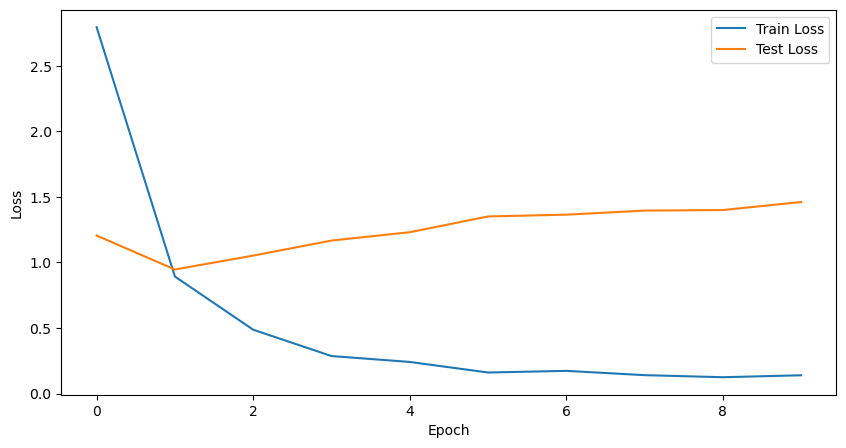

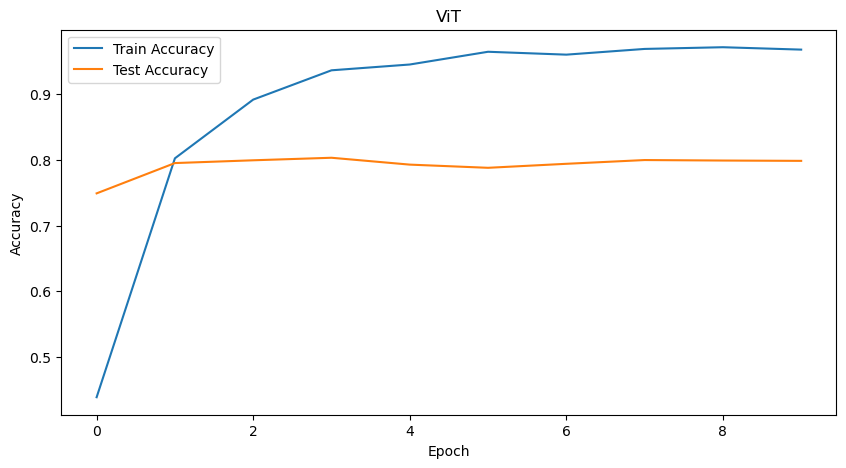

In [ ]:
import torch
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm

def train_one_epoch(model, dataloader, loss_fn, optimizer, device):
    model.train()
    total_loss, total_correct = 0, 0
    scaler = GradScaler()

    for inputs, labels in tqdm(dataloader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        with autocast():
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)

        scaler.scale(loss).backward()

        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        total_correct += torch.sum(preds == labels.data)

    return total_loss / len(dataloader), total_correct.double() / len(dataloader.dataset)


from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision.models import vit_b_16, ViT_B_16_Weights

# ViT Model
class ViTModel(nn.Module):
    def __init__(self, num_classes):
        super(ViTModel, self).__init__()
        self.vit = torchvision.models.vit_b_16(weights=ViT_B_16_Weights.IMAGENET1K_V1)
        for param in self.vit.parameters():
            param.requires_grad = False
        self.fc = nn.Linear(1000, num_classes)

    def forward(self, x):
        x = self.vit(x)
        return self.fc(x)

# Best hyperparameters
batch_size = 48
learning_rate = 0.00084
num_unfreeze_layers = 4
epochs = 10 # increase epochs for final training

train_loader = DataLoader(train_dataset_no_threshold, batch_size=batch_size, shuffle=True, num_workers=8)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=8)

# model, optimizer, and loss function initialization
model = ViTModel(num_classes=len(class_names)).to(device)

# Unfreeze layers
unfreeze_layers(model, num_unfreeze_layers)

# Incorporate scheduler
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, verbose=True)
loss_fn = nn.CrossEntropyLoss()

metrics = {'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': []}

# training loop
for epoch in range(epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, loss_fn, optimizer, device)
    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.3f}, Train Accuracy: {train_acc:.3f}')

    test_loss, test_acc = evaluate(model, test_loader, loss_fn, device)
    print(f'Test Loss: {test_loss:.3f}, Test Accuracy: {test_acc:.3f}')

    # Update the learning rate scheduler with the validation/test loss
    scheduler.step(test_loss)

    metrics['train_loss'].append(train_loss)
    metrics['train_acc'].append(train_acc.item())
    metrics['test_loss'].append(test_loss)
    metrics['test_acc'].append(test_acc.item())

# visualization
plt.figure(figsize=(10, 5))
plt.plot(metrics['train_loss'], label='Train Loss')
plt.plot(metrics['test_loss'], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(metrics['train_acc'], label='Train Accuracy')
plt.plot(metrics['test_acc'], label='Test Accuracy')
plt.title("ViT")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Hyperparameter Tuning

In [ ]:
class ViTModel(nn.Module):
    def __init__(self, num_classes):
        super(ViTModel, self).__init__()
        self.vit = torchvision.models.vit_b_16(pretrained=True)  # Assuming this is the vit model
        # Modification to the classification head here, if necessary
        self.fc = nn.Linear(1000, num_classes)  # Adjust as per the original model specification

    def forward(self, x):
        x = self.vit(x)
        x = self.fc(x)
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
import optuna
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
import torchvision.models as models
from tqdm import tqdm
import numpy as np

# Set logging level
optuna.logging.set_verbosity(optuna.logging.INFO)

def objective(trial):
    # Tuning hyperparameters more narrowly around previously successful values
    learning_rate = trial.suggest_float('learning_rate', 0.00001, 0.0001, log=True)
    batch_size = trial.suggest_categorical('batch_size', [48, 64, 80])
    num_unfreeze_layers = trial.suggest_categorical('num_unfreeze_layers', [3, 4, 5])

    # Setup model and unfreeze appropriate blocks
    model = ViTModel(num_classes=len(class_names)).to(device)

    # Freeze all parameters initially
    for param in model.parameters():
        param.requires_grad = False

    # Unfreeze layers
    encoder_layers = model.vit.encoder.layers
    num_blocks = len(encoder_layers)  # Total number of encoder blocks
    blocks_to_unfreeze = num_blocks - num_unfreeze_layers

    # Unfreeze the specified last layers
    for i in range(blocks_to_unfreeze, num_blocks):
        for param in encoder_layers[i].parameters():
            param.requires_grad = True

    params_to_optimize = [param for param in model.parameters() if param.requires_grad]
    if not params_to_optimize:
        raise ValueError("No parameters to optimize. Check the logic for unfreezing layers.")

    optimizer = torch.optim.Adam(params_to_optimize, lr=learning_rate)
    loss_fn = nn.CrossEntropyLoss()

    # Training loop
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8)
    model.train()
    for epoch in range(10):
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

    # Evaluation loop
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=8)
    model.eval()
    total_correct = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            total_correct += torch.sum(preds == labels.data)

    accuracy = total_correct.double() / len(test_loader.dataset)
    print(f"Trial {trial.number}: Accuracy={accuracy}")
    return accuracy.item()

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

[I 2024-05-01 14:14:57,083] A new study created in memory with name: no-name-d7f86626-dd06-41aa-86de-b4179ce60750
/home/yuling/miniconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/yuling/miniconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
[I 2024-05-01 14:20:09,637] Trial 0 finished with value: 0.8066160925258052 and parameters: {'learning_rate': 4.323756343220704e-05, 'batch_size': 80, 'num_unfreeze_layers': 3}. Best is trial 0 with value: 0.8066160925258052.


Trial 0: Accuracy=0.8066160925258052


[I 2024-05-01 14:26:28,185] Trial 1 finished with value: 0.841064544210919 and parameters: {'learning_rate': 4.765280229085674e-05, 'batch_size': 48, 'num_unfreeze_layers': 5}. Best is trial 1 with value: 0.841064544210919.


Trial 1: Accuracy=0.841064544210919


[I 2024-05-01 14:31:43,618] Trial 2 finished with value: 0.8017659495087676 and parameters: {'learning_rate': 2.733505362342553e-05, 'batch_size': 64, 'num_unfreeze_layers': 3}. Best is trial 1 with value: 0.841064544210919.


Trial 2: Accuracy=0.8017659495087676


[I 2024-05-01 14:37:23,465] Trial 3 finished with value: 0.8186792687476682 and parameters: {'learning_rate': 9.041297305268112e-05, 'batch_size': 80, 'num_unfreeze_layers': 4}. Best is trial 1 with value: 0.841064544210919.


Trial 3: Accuracy=0.8186792687476682


[I 2024-05-01 14:42:44,681] Trial 4 finished with value: 0.814699664220868 and parameters: {'learning_rate': 6.621299311139246e-05, 'batch_size': 48, 'num_unfreeze_layers': 3}. Best is trial 1 with value: 0.841064544210919.


Trial 4: Accuracy=0.814699664220868


[I 2024-05-01 14:49:02,258] Trial 5 finished with value: 0.8331053351573187 and parameters: {'learning_rate': 3.868910974252212e-05, 'batch_size': 48, 'num_unfreeze_layers': 5}. Best is trial 1 with value: 0.841064544210919.


Trial 5: Accuracy=0.8331053351573187


[I 2024-05-01 14:55:12,057] Trial 6 finished with value: 0.789080960079592 and parameters: {'learning_rate': 1.2638259426559499e-05, 'batch_size': 80, 'num_unfreeze_layers': 5}. Best is trial 1 with value: 0.841064544210919.


Trial 6: Accuracy=0.789080960079592


[I 2024-05-01 15:01:02,156] Trial 7 finished with value: 0.8314886208183061 and parameters: {'learning_rate': 7.118600920061078e-05, 'batch_size': 48, 'num_unfreeze_layers': 4}. Best is trial 1 with value: 0.841064544210919.


Trial 7: Accuracy=0.8314886208183061


[I 2024-05-01 15:06:44,465] Trial 8 finished with value: 0.7601044646188284 and parameters: {'learning_rate': 1.0050114229367966e-05, 'batch_size': 64, 'num_unfreeze_layers': 4}. Best is trial 1 with value: 0.841064544210919.


Trial 8: Accuracy=0.7601044646188284


[I 2024-05-01 15:12:25,735] Trial 9 finished with value: 0.8221614227086183 and parameters: {'learning_rate': 3.95146221405181e-05, 'batch_size': 80, 'num_unfreeze_layers': 4}. Best is trial 1 with value: 0.841064544210919.


Trial 9: Accuracy=0.8221614227086183


[I 2024-05-01 15:18:42,446] Trial 10 finished with value: 0.8250217634622559 and parameters: {'learning_rate': 2.268373184287313e-05, 'batch_size': 48, 'num_unfreeze_layers': 5}. Best is trial 1 with value: 0.841064544210919.


Trial 10: Accuracy=0.8250217634622559


[I 2024-05-01 15:24:59,878] Trial 11 finished with value: 0.840567093645069 and parameters: {'learning_rate': 4.892510091753346e-05, 'batch_size': 48, 'num_unfreeze_layers': 5}. Best is trial 1 with value: 0.841064544210919.


Trial 11: Accuracy=0.840567093645069


[I 2024-05-01 15:31:16,561] Trial 12 finished with value: 0.8349707747792563 and parameters: {'learning_rate': 5.475040869033287e-05, 'batch_size': 48, 'num_unfreeze_layers': 5}. Best is trial 1 with value: 0.841064544210919.


Trial 12: Accuracy=0.8349707747792563


[I 2024-05-01 15:37:34,602] Trial 13 finished with value: 0.840567093645069 and parameters: {'learning_rate': 5.2361478078919615e-05, 'batch_size': 48, 'num_unfreeze_layers': 5}. Best is trial 1 with value: 0.841064544210919.


Trial 13: Accuracy=0.840567093645069


[I 2024-05-01 15:43:51,784] Trial 14 finished with value: 0.8313642581768436 and parameters: {'learning_rate': 9.883012123482153e-05, 'batch_size': 48, 'num_unfreeze_layers': 5}. Best is trial 1 with value: 0.841064544210919.


Trial 14: Accuracy=0.8313642581768436


[I 2024-05-01 15:50:08,904] Trial 15 finished with value: 0.8312398955353811 and parameters: {'learning_rate': 3.0322054376133572e-05, 'batch_size': 48, 'num_unfreeze_layers': 5}. Best is trial 1 with value: 0.841064544210919.


Trial 15: Accuracy=0.8312398955353811


[I 2024-05-01 15:56:20,391] Trial 16 finished with value: 0.8388260166645939 and parameters: {'learning_rate': 5.228306440404722e-05, 'batch_size': 64, 'num_unfreeze_layers': 5}. Best is trial 1 with value: 0.841064544210919.


Trial 16: Accuracy=0.8388260166645939


[I 2024-05-01 16:02:37,831] Trial 17 finished with value: 0.8270115657256559 and parameters: {'learning_rate': 2.2550323912326312e-05, 'batch_size': 48, 'num_unfreeze_layers': 5}. Best is trial 1 with value: 0.841064544210919.


Trial 17: Accuracy=0.8270115657256559


[I 2024-05-01 16:08:54,223] Trial 18 finished with value: 0.842059445342619 and parameters: {'learning_rate': 7.022870756860868e-05, 'batch_size': 48, 'num_unfreeze_layers': 5}. Best is trial 18 with value: 0.842059445342619.


Trial 18: Accuracy=0.842059445342619


[I 2024-05-01 16:14:09,230] Trial 19 finished with value: 0.8194254445964432 and parameters: {'learning_rate': 7.419509525530316e-05, 'batch_size': 64, 'num_unfreeze_layers': 3}. Best is trial 18 with value: 0.842059445342619.


Trial 19: Accuracy=0.8194254445964432


In [ ]:
# Best hyperparameters
print("Best trial:")
trial = study.best_trial
print(f"  Value: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

Best trial:
  Value: 0.842059445342619
  Params: 
    learning_rate: 7.022870756860868e-05
    batch_size: 48
    num_unfreeze_layers: 5


In [ ]:
import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances, plot_slice, plot_contour

# Optimization History
history_plot = plot_optimization_history(study)
history_plot.show()

# Parameter Importances
importance_plot = plot_param_importances(study)
importance_plot.show()

# Slice Plot
slice_plot = plot_slice(study)
slice_plot.show()

# Contour Plot of Parameter Interactions
contour_plot = plot_contour(study, params=['learning_rate', 'batch_size', 'num_unfreeze_layers'])
contour_plot.show()

## Train pretrained ViT based on best hyperparameters combination

100%|██████████| 289/289 [00:18<00:00, 15.54it/s]


Epoch 1, Train Loss: 3.722, Train Accuracy: 0.320


100%|██████████| 168/168 [00:11<00:00, 14.09it/s]


Test Loss: 2.371, Test Accuracy: 0.656


100%|██████████| 289/289 [00:18<00:00, 15.33it/s]


Epoch 2, Train Loss: 1.533, Train Accuracy: 0.817


100%|██████████| 168/168 [00:11<00:00, 14.05it/s]


Test Loss: 1.270, Test Accuracy: 0.806


100%|██████████| 289/289 [00:18<00:00, 15.64it/s]


Epoch 3, Train Loss: 0.633, Train Accuracy: 0.942


100%|██████████| 168/168 [00:11<00:00, 14.10it/s]


Test Loss: 0.931, Test Accuracy: 0.829


100%|██████████| 289/289 [00:18<00:00, 15.83it/s]


Epoch 4, Train Loss: 0.267, Train Accuracy: 0.984


100%|██████████| 168/168 [00:12<00:00, 13.90it/s]


Test Loss: 0.853, Test Accuracy: 0.834


100%|██████████| 289/289 [00:18<00:00, 15.29it/s]


Epoch 5, Train Loss: 0.126, Train Accuracy: 0.993


100%|██████████| 168/168 [00:12<00:00, 13.99it/s]


Test Loss: 0.830, Test Accuracy: 0.837


100%|██████████| 289/289 [00:17<00:00, 16.18it/s]


Epoch 6, Train Loss: 0.079, Train Accuracy: 0.996


100%|██████████| 168/168 [00:12<00:00, 13.88it/s]


Test Loss: 0.832, Test Accuracy: 0.840


100%|██████████| 289/289 [00:18<00:00, 15.33it/s]


Epoch 7, Train Loss: 0.055, Train Accuracy: 0.997


100%|██████████| 168/168 [00:11<00:00, 14.26it/s]


Test Loss: 0.886, Test Accuracy: 0.834


100%|██████████| 289/289 [00:18<00:00, 15.45it/s]


Epoch 8, Train Loss: 0.047, Train Accuracy: 0.997


100%|██████████| 168/168 [00:11<00:00, 14.10it/s]


Test Loss: 0.879, Test Accuracy: 0.835


100%|██████████| 289/289 [00:18<00:00, 15.52it/s]


Epoch 9, Train Loss: 0.047, Train Accuracy: 0.996


100%|██████████| 168/168 [00:12<00:00, 13.94it/s]


Test Loss: 0.908, Test Accuracy: 0.826


100%|██████████| 289/289 [00:18<00:00, 15.83it/s]


Epoch 10, Train Loss: 0.039, Train Accuracy: 0.997


100%|██████████| 168/168 [00:12<00:00, 13.94it/s]

Test Loss: 0.901, Test Accuracy: 0.843


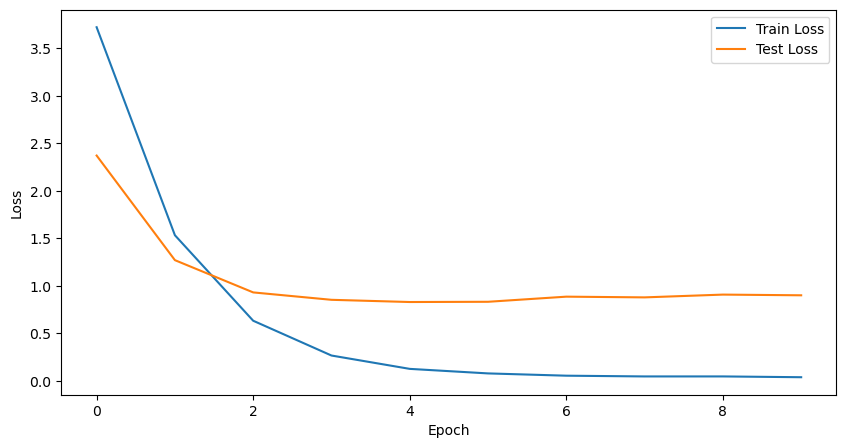

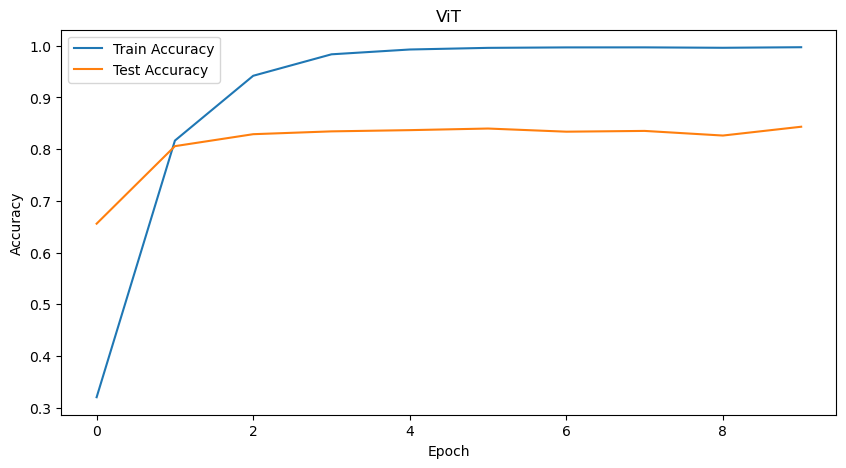

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision.models import vit_b_16, ViT_B_16_Weights

import torch
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm

def train_one_epoch(model, dataloader, loss_fn, optimizer, device):
    model.train()
    total_loss, total_correct = 0, 0
    scaler = GradScaler()

    for inputs, labels in tqdm(dataloader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        with autocast():
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)

        scaler.scale(loss).backward()

        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        total_correct += torch.sum(preds == labels.data)

    return total_loss / len(dataloader), total_correct.double() / len(dataloader.dataset)

# ViT Model
class ViTModel(nn.Module):
    def __init__(self, num_classes):
        super(ViTModel, self).__init__()
        self.vit = torchvision.models.vit_b_16(weights=ViT_B_16_Weights.IMAGENET1K_V1)
        for param in self.vit.parameters():
            param.requires_grad = False
        self.fc = nn.Linear(1000, num_classes)

    def forward(self, x):
        x = self.vit(x)
        return self.fc(x)

# {'learning_rate': 7.022870756860868e-05, 'batch_size': 48, 'num_unfreeze_layers': 5}
epochs = 10
trial = study.best_trial
batch_size = trial.params['batch_size']
learning_rate = trial.params['learning_rate']
num_unfreeze_layers = trial.params['num_unfreeze_layers']

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=8)

# model, optimizer, and loss function initialization
model = ViTModel(num_classes=len(class_names)).to(device)

# Unfreeze layers
unfreeze_layers(model, num_unfreeze_layers)

# Incorporate scheduler
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

metrics = {'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': []}

# training loop
for epoch in range(epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, loss_fn, optimizer, device)
    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.3f}, Train Accuracy: {train_acc:.3f}')

    test_loss, test_acc = evaluate(model, test_loader, loss_fn, device)
    print(f'Test Loss: {test_loss:.3f}, Test Accuracy: {test_acc:.3f}')

    metrics['train_loss'].append(train_loss)
    metrics['train_acc'].append(train_acc.item())
    metrics['test_loss'].append(test_loss)
    metrics['test_acc'].append(test_acc.item())

# visualization
plt.figure(figsize=(10, 5))
plt.plot(metrics['train_loss'], label='Train Loss')
plt.plot(metrics['test_loss'], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(metrics['train_acc'], label='Train Accuracy')
plt.plot(metrics['test_acc'], label='Test Accuracy')
plt.title("ViT")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# save the model
Vit_path = './Vit_path_pseudo.pth'

torch.save(model.state_dict(), Vit_path)

### Evaluate and compare the model with previous version without pseudo labeling

**We can see that the accuracy of the model trained with pseudo labeling is significantly higher than the model trained without pseudo labeling.**

In [ ]:
from torchvision.models import vit_b_16, ViT_B_16_Weights

class ViTModel(nn.Module):
    def __init__(self, num_classes):
        super(ViTModel, self).__init__()
        self.vit = torchvision.models.vit_b_16(weights=ViT_B_16_Weights.IMAGENET1K_V1)
        for param in self.vit.parameters():
            param.requires_grad = False
        self.fc = nn.Linear(1000, num_classes)

    def forward(self, x):
        x = self.vit(x)
        return self.fc(x)


Vit_path_pseudo = './Vit_path_pseudo.pth'
Vit_path = './Vit_path.pth'
batch_size = 64

# Compare the performance
# Load the model
model_pseudo = ViTModel(num_classes=len(class_names)).to(device)
model_pseudo.load_state_dict(torch.load(Vit_path_pseudo))
model_pseudo.eval()

model = ViTModel(num_classes=len(class_names)).to(device)
model.load_state_dict(torch.load(Vit_path))
model.eval()

# Evaluate the models
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=8)

loss_fn = nn.CrossEntropyLoss()

def evaluate(model, dataloader, loss_fn, device):
    model.eval()
    total_loss, total_correct = 0, 0
    all_predictions = []
    all_confidence = []
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            softmax_scores = nn.functional.softmax(outputs, dim=1)
            confidence = torch.max(softmax_scores, 1).values
            loss = loss_fn(outputs, labels)
            total_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            total_correct += torch.sum(preds == labels.data)
            all_predictions.extend(preds.cpu().numpy())
            all_confidence.extend(confidence.cpu().numpy())
    return total_loss / len(dataloader), total_correct.double() / len(dataloader.dataset), all_predictions, all_confidence

test_loss, test_acc, all_predictions, all_confidence = evaluate(model, test_loader, loss_fn, device)
print(f'Test Loss: {test_loss:.3f}, Test Accuracy: {test_acc*100:.3f}')

test_loss_pseudo, test_acc_pseudo, all_predictions_pseudo, all_confidence_pseudo = evaluate(model_pseudo, test_loader, loss_fn, device)
print(f'Pseudo Model Test Loss: {test_loss_pseudo:.3f}, Pseudo Model Test Accuracy: {test_acc_pseudo*100:.3f}')

100%|██████████| 126/126 [00:12<00:00, 10.32it/s]


Test Loss: 1.241, Test Accuracy: 80.587


100%|██████████| 126/126 [00:11<00:00, 10.69it/s]

Pseudo Model Test Loss: 0.900, Pseudo Model Test Accuracy: 84.343


### Confusion Matrix

We can see that both models make mistakes around classes 12~24, this is because that pseudo labels reinforces the patterns that the model has learned from the original dataset. And these classes might be inherently hard to classify.

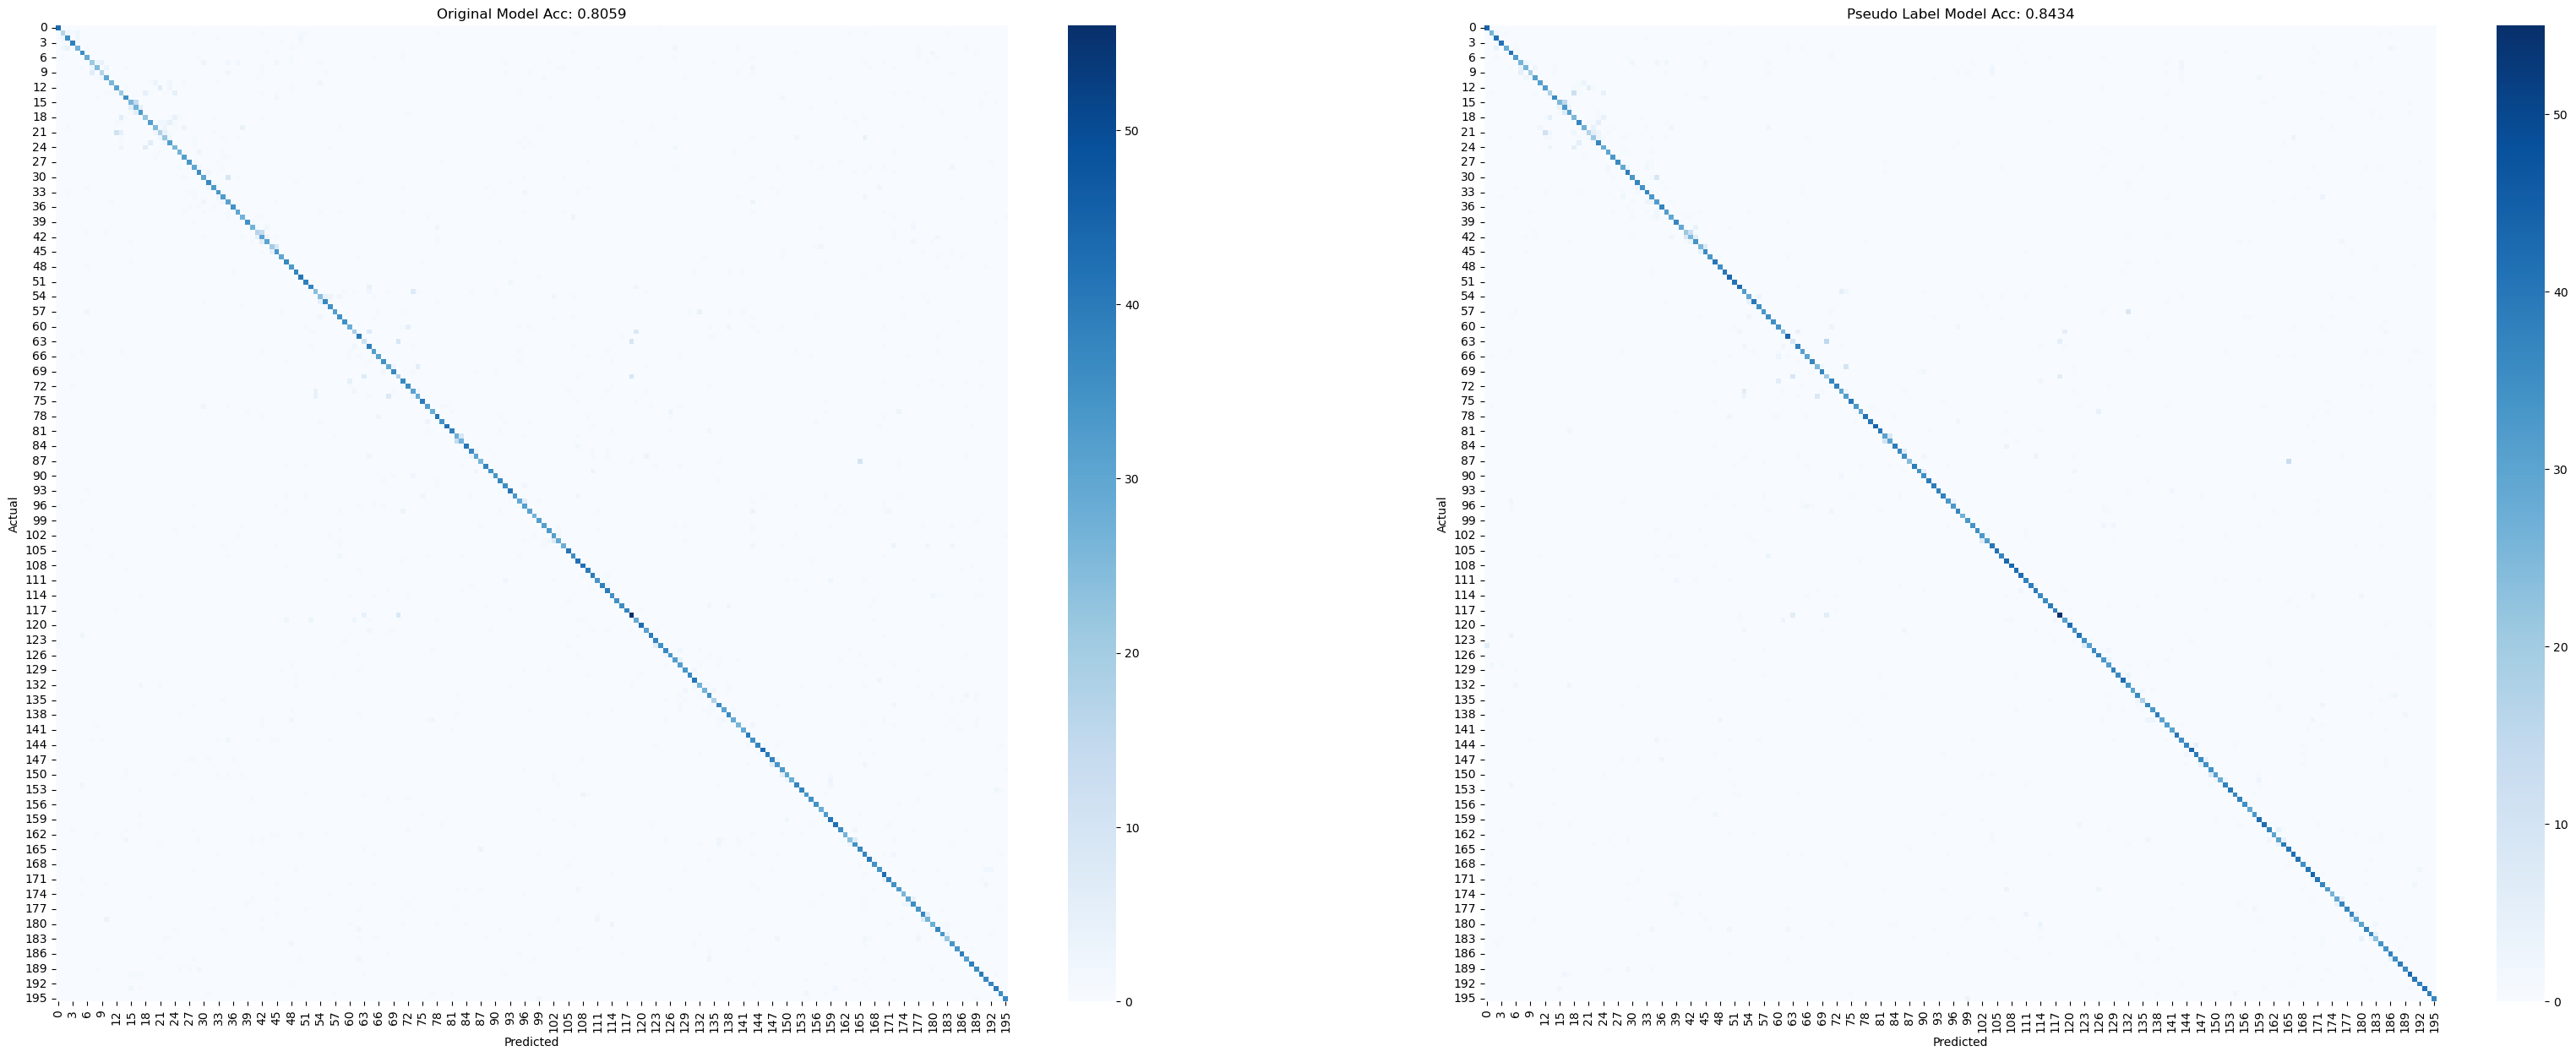

In [ ]:
# iterate over the test dataset and show the label
all_labels = []
for i, (inputs, labels) in enumerate(test_loader):
    all_labels.extend(labels.cpu().numpy())

# visualize the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(all_labels, all_predictions)
cm_pseudo = confusion_matrix(all_labels, all_predictions_pseudo)

# plot the confusion matrix with 2*1 subplots
fig, ax = plt.subplots(1, 2, figsize=(40, 15))
sns.heatmap(cm, annot=False, cmap='Blues', ax=ax[0])
ax[0].set_title('Original Model Acc: {:.4f}'.format(test_acc.item()))
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('Actual')

sns.heatmap(cm_pseudo, annot=False, cmap='Blues', ax=ax[1])
ax[1].set_title('Pseudo Label Model Acc: {:.4f}'.format(test_acc_pseudo.item()))
ax[1].set_xlabel('Predicted')
ax[1].set_ylabel('Actual')

plt.show()

### Cases where the new model performs better

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


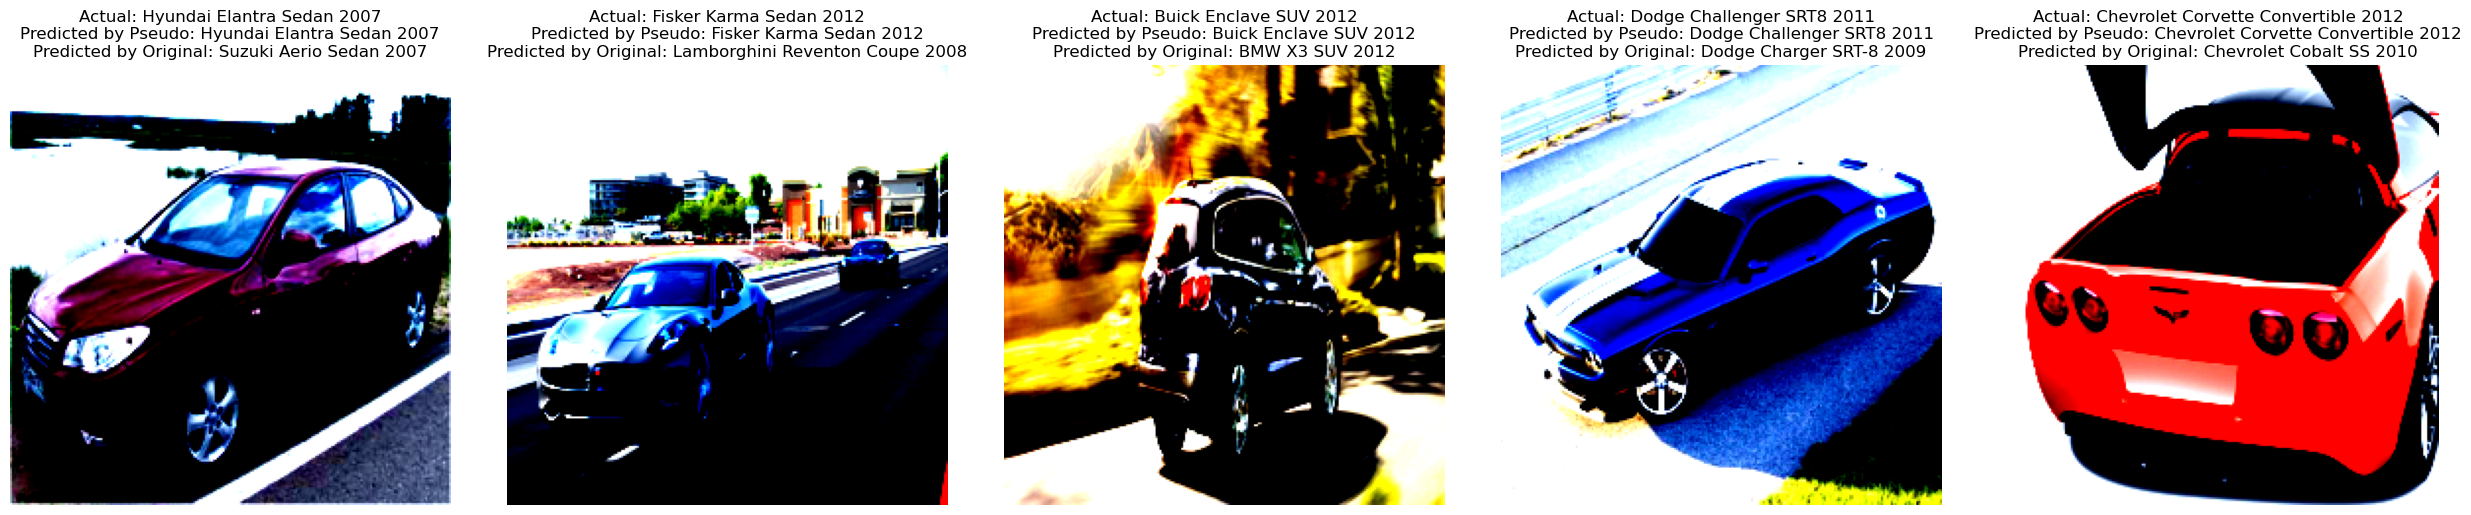

In [ ]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

# Function to display images in a grid
def show_images(images, titles, rows=1, cols=1):
    fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=(cols * 5, rows * 5))
    for i, ax in enumerate(axs.flatten()):
        img = images[i].cpu().permute(1, 2, 0)
        img = img.numpy()
        ax.imshow(img)
        ax.set_title(titles[i])
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Find instances where predictions differ and pseudo is correct
correct_by_pseudo = []
wrong_by_original = []
for i in range(len(all_labels)):
    if all_labels[i] != all_predictions[i] and all_labels[i] == all_predictions_pseudo[i]:
        correct_by_pseudo.append(i)
        wrong_by_original.append(i)

# Choose a few examples to display
examples_to_show = 5
chosen_indices = correct_by_pseudo[:examples_to_show]

# Load these images and corresponding labels
images_to_show = []
titles = []
for idx in chosen_indices:
    image, label = test_dataset[idx]
    images_to_show.append(image)
    predicted_label_pseudo = class_names[all_predictions_pseudo[idx]]
    actual_label = class_names[label]
    titles.append(f'Actual: {actual_label}\nPredicted by Pseudo: {predicted_label_pseudo}\nPredicted by Original: {class_names[all_predictions[idx]]}')

# Display these images with labels
show_images(images_to_show, titles, rows=1, cols=examples_to_show)

### Classification Report

In [ ]:
from sklearn.metrics import classification_report

# Classification report for original model
print("Original Model Classification Report")
print(classification_report(all_labels, all_predictions, target_names=class_names, digits=4))

# Classification report for pseudo label model
print("Pseudo Label Model Classification Report")
print(classification_report(all_labels, all_predictions_pseudo, target_names=class_names, digits=4))

Original Model Classification Report
                                                        precision    recall  f1-score   support

                            AM General Hummer SUV 2000     0.9149    0.9773    0.9451        44
                                   Acura RL Sedan 2012     0.7391    0.5312    0.6182        32
                                   Acura TL Sedan 2012     0.8182    0.8372    0.8276        43
                                  Acura TL Type-S 2008     0.9070    0.9286    0.9176        42
                                  Acura TSX Sedan 2012     0.8710    0.6750    0.7606        40
                             Acura Integra Type R 2001     0.8000    0.8182    0.8090        44
                              Acura ZDX Hatchback 2012     0.7838    0.7436    0.7632        39
              Aston Martin V8 Vantage Convertible 2012     0.6562    0.4667    0.5455        45
                    Aston Martin V8 Vantage Coupe 2012     0.7576    0.6098    0.6757        41
  

### Accuracy by class

We can see that the model trained with pseudo labeling has higher accuracy for most classes compared to the model trained without pseudo labeling.

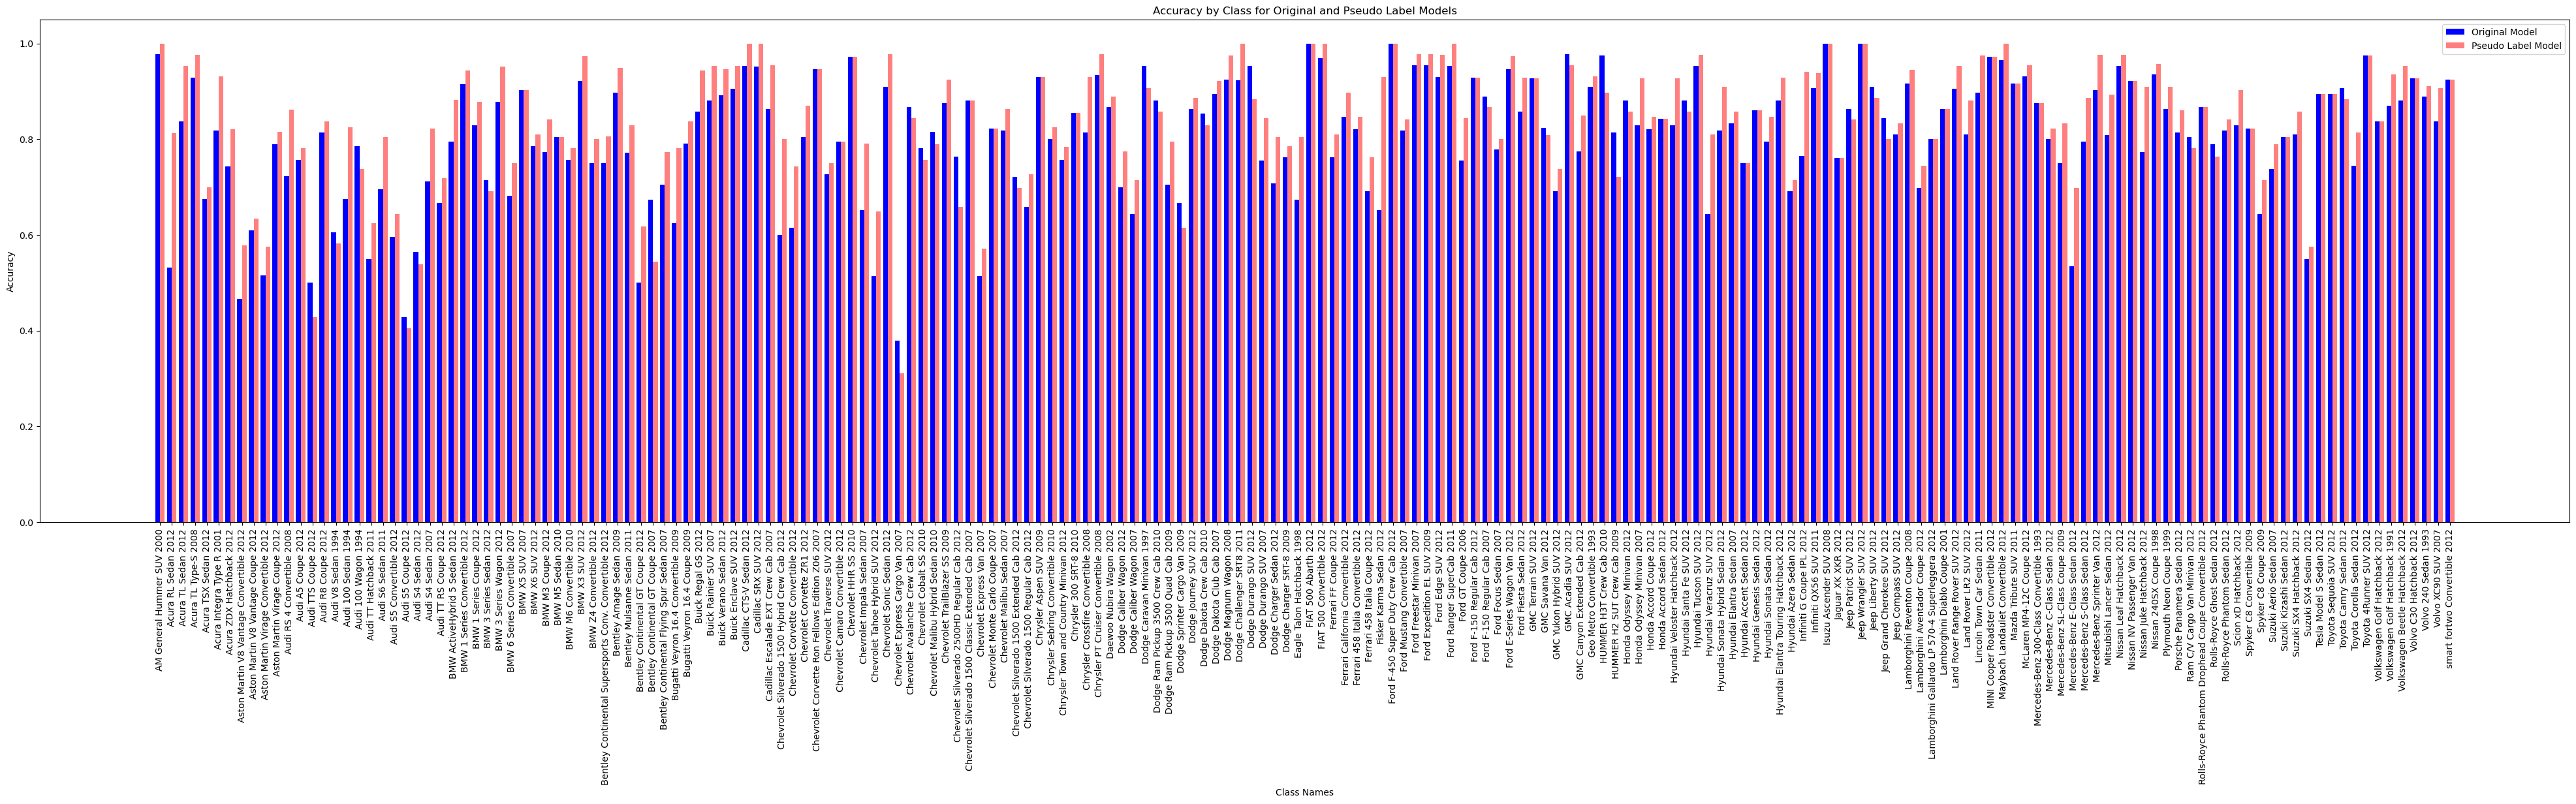

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

class_correct = cm.diagonal() / cm.sum(axis=1)
class_correct_pseudo = cm_pseudo.diagonal() / cm.sum(axis=1)

# Data preparation
class_indices = np.arange(len(class_names))  # Create indices for class names

# Plotting
plt.figure(figsize=(50, 10))
# Plot for the original model
plt.bar(class_indices - 0.2, class_correct, width=0.4, color='blue', label='Original Model')
# Plot for the pseudo label model
plt.bar(class_indices + 0.2, class_correct_pseudo, width=0.4, color='red', alpha=0.5, label='Pseudo Label Model')

plt.ylabel('Accuracy')
plt.title('Accuracy by Class for Original and Pseudo Label Models')
plt.xticks(class_indices, labels=class_names, rotation=90)  # Show class names vertically
plt.xlabel('Class Names')
plt.legend()
plt.show()